## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# for neural network
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.resnet import resnet18
from copy import deepcopy

# for splitting data and evaluating
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score

# to track progress
from tqdm.notebook import tqdm

In [2]:
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## get data

In [3]:
transform = transforms.Compose([transforms.Resize(size=(224, 224))])

train_dataset = torchvision.datasets.VOCSegmentation(
    root="./data", image_set="train", transform=transform, download=True
)

test_dataset = torchvision.datasets.VOCSegmentation(
    root="./data", image_set="val",transform=transform,  download=True
)


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [4]:
train_inputs, train_outputs = zip(*train_dataset)
test_inputs, test_outputs = zip(*test_dataset)

def transformOutput(x, transform):
  return [transform(i) for i in x]

train_outputs = transformOutput(train_outputs, transform)
test_outputs = transformOutput(test_outputs, transform)

def toNumpy(x):
  return np.array([np.array(i) for i in x])

train_inputs, train_outputs = toNumpy(train_inputs), toNumpy(train_outputs)
test_inputs, test_outputs = toNumpy(test_inputs), toNumpy(test_outputs)

# split train into train and validation
train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(train_inputs, train_outputs, test_size=0.25, random_state=0)

print("shapes")
print("train_inputs",train_inputs.shape)
print("train_outputs",train_outputs.shape)
print()
print("test_inputs",test_inputs.shape)
print("test_outputs",test_outputs.shape)
print()
print("val_inputs",val_inputs.shape)
print("val_outputs",val_outputs.shape)

shapes
train_inputs (1098, 224, 224, 3)
train_outputs (1098, 224, 224)

test_inputs (1449, 224, 224, 3)
test_outputs (1449, 224, 224)

val_inputs (366, 224, 224, 3)
val_outputs (366, 224, 224)


In [5]:
def trans_out(x):
  x[x==255] = 21

trans_out(train_outputs)
trans_out(test_outputs)
trans_out(val_outputs)

classes = np.unique(train_outputs)
print("classes:", classes)
print(len(classes))

classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
22


classes and colors


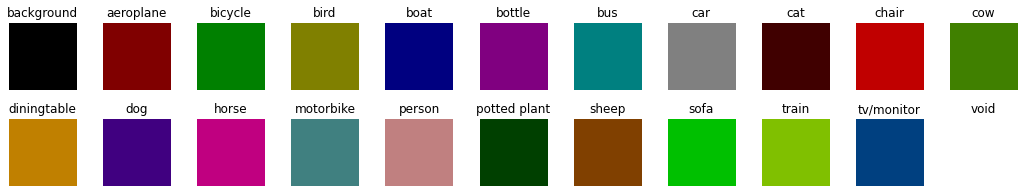

In [6]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
    "void",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
    [255, 255, 255],
]

print("classes and colors")
fig, axs = plt.subplots(2,11, figsize=(10,10))
for i, (claSS, col) in enumerate(zip(VOC_CLASSES ,VOC_COLORMAP)):
  img = np.full((1,1,3),col)
  ax = axs[i//11][i%11]
  ax.imshow(img)
  ax.set_axis_off()
  ax.set_title(claSS)
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=-0.8)

## visualize

In [7]:
def get_mask(img, cols=VOC_COLORMAP):
  h,w = img.shape
  img = img.flatten()
  img = np.array(cols)[img]
  img = img.reshape((h,w,3))
  return img

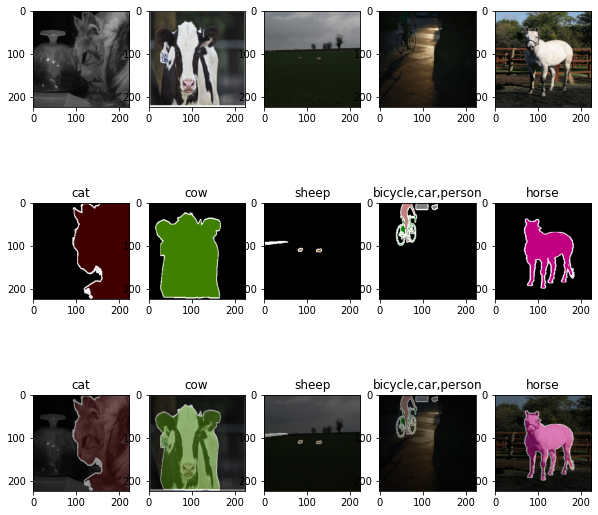

In [8]:
n_samples = 5
fig, axs = plt.subplots(3,n_samples, figsize=(10,10))

for i in range(n_samples):
  img = train_inputs[i]
  seg = get_mask(train_outputs[i])
  classes = np.array(VOC_CLASSES)[np.unique(train_outputs[i])]
  classes = classes[1:-1]   # ignore background and void class
  classes = ",".join(classes)

  axs[0][i].imshow(img)
  axs[2][i].imshow(img)
  axs[1][i].imshow(seg)
  axs[1][i].set_title(classes)
  axs[2][i].imshow(seg, alpha=0.5)
  axs[2][i].set_title(classes)
plt.show()

## create dataset and dataloader

In [9]:
# custom dataset class
class mydataset(Dataset):
  def __init__(self, inputs, outputs, trans_in, trans_out):
    self.inputs = inputs
    self.outputs = outputs
    self.trans_in = trans_in
    self.trans_out = trans_out

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.trans_in(self.inputs[index])
    output = self.trans_out(self.outputs[index])
    return input,output


# custom transform to prevent rescaling to [0,1]
class ToTensorWithoutScaling(object):
    def __call__(self, image):    # H x W x C -> C x H x W
        return torch.ByteTensor(np.array(image)).unsqueeze(2).permute(2, 0, 1)

trans_in = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

trans_out = transforms.Compose([ToTensorWithoutScaling()])

train_dataset = mydataset(train_inputs, train_outputs, trans_in, trans_out)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = mydataset(test_inputs, test_outputs, trans_in, trans_out)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

val_dataset = mydataset(val_inputs, val_outputs, trans_in, trans_out)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

dataloaders = {"train":train_loader, "val":val_loader}

## define train function

In [10]:
def train_model(model,criterion,optimizer,dataloaders,epochs,check_every=None,earlyStopping=False):

  print("training model")
  optimizer.zero_grad()

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  phases = dataloaders.keys()
  valExists = True if "val" in phases else False
  avg_loss = {phase:0 for phase in phases}
  avg_losses = {phase:[] for phase in phases}

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    batchLoss = {phase:[] for phase in phases}

     # Each epoch has a training and validation phase
    for phase in phases:
      if phase == "train":  model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode  
        
      for i, (inputBatch,outTrueBatch) in enumerate(tqdm(dataloaders[phase], leave=False)):
        
        inputBatch = inputBatch.to(device).float()
        outTrueBatch = outTrueBatch.to(device).squeeze().long() 

        # forward
        with torch.set_grad_enabled(not phase=="val"):
          outPredBatch = model(inputBatch)
        loss = criterion(outPredBatch, outTrueBatch)
        batchLoss[phase].append(loss.item())

        # backward + optimize only if in training phase
        if phase == "train":
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


    for phase in phases : avg_loss[phase] = np.mean(batchLoss[phase])
        
    phase = "val" if valExists else "train"
    if epoch > 0:
      if avg_loss[phase] < min(avg_losses[phase]):
        best_params = deepcopy(model.state_dict())
        best_epoch, best_loss = epoch, avg_loss[phase]
    else:
      best_params = deepcopy(model.state_dict())
      best_epoch, best_loss = epoch, avg_loss[phase]
      movAvg_old = avg_loss[phase]

    for phase in phases : avg_losses[phase].append(avg_loss[phase])  

    # print statistics
    if epoch % check_every == check_every - 1:
      print("epoch: %d" % (epoch + 1), end="  | ")
      for phase in phases:
        print("%s loss: %.3f" % (phase, avg_loss[phase]), end=", ")
      print(" | ", end='')
      for phase in phases:        
        print("avg %s loss: %.3f" % (phase, np.mean(avg_losses[phase][epoch+1-check_every:epoch+1])), end=", ")
      if valExists:
        movAvg_new = np.mean(avg_losses["val"][epoch+1-check_every:epoch+1])

      if (valExists) and earlyStopping:
        if movAvg_old < movAvg_new:   break
        else:   movAvg_old = movAvg_new



  last_params = deepcopy(model.state_dict())
  print('Finished Training')
  for phase in phases:  plt.plot(avg_losses[phase], label=phase+" loss")
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params, last_params

In [11]:
class EncDec(nn.Module):
  def __init__(self):
    super(EncDec, self).__init__()

    self.encoder = nn.Sequential(     #224
      nn.Conv2d(3, 32, 3, stride=2),    nn.ReLU(True),  #111
      nn.Conv2d(32, 64, 3, stride=2),   nn.ReLU(True),   #55
      nn.Conv2d(64, 128, 3, stride=2),  nn.ReLU(True),   #27
      nn.Conv2d(128, 256, 3, stride=2),  #13
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(256, 128, 3, stride=2),    nn.ReLU(True),    #27
      nn.ConvTranspose2d(128, 64, 3, stride=2),     nn.ReLU(True),   #55
      nn.ConvTranspose2d(64, 32, 3, stride=2),      nn.ReLU(True),   #111
      nn.ConvTranspose2d(32, 22, 3, stride=2, output_padding=1),  #224
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [12]:
class EncDec(nn.Module):
  def __init__(self):
    super(EncDec, self).__init__()

    self.encoder = resnet18(pretrained=True).to(device)
    # remove the last two layers by setting them to identity
    self.encoder.avgpool = torch.nn.Identity()    # 512*7*7 -> 512*1*1
    self.encoder.fc = torch.nn.Identity()         # 512 -> 1000

    self.decoder = nn.Sequential(     #7
      nn.ConvTranspose2d(512, 350, 3, stride=2),  nn.ReLU(True),   #15
      nn.ConvTranspose2d(350, 256, 3, stride=2),  nn.ReLU(True),   #31
      nn.ConvTranspose2d(256, 128, 3, stride=2),  nn.ReLU(True),   #21
      nn.ConvTranspose2d(128, 64, 3, stride=2),  nn.ReLU(True),   #63
      nn.ConvTranspose2d(64, 32, 3, stride=2),  nn.ReLU(True),   #127
      nn.ConvTranspose2d(32, 22, 3, stride=2)  #255
    )
    
  def forward(self, x):
    x = self.encoder(x)
    x = x.view(-1,512,7,7)
    x = self.decoder(x)
    x = nn.functional.interpolate(x,224)
    return x

## create model and train

In [13]:
model = EncDec().to(device)
# dont train encoder
for param in model.encoder.parameters():  param.requires_grad_(False)
print("params:",sum(p.numel() for p in model.parameters() if p.requires_grad))

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



params: 2813460


training model


epoch: 5  | train loss: 1.188, val loss: 1.317,  | avg train loss: 1.402, avg val loss: 1.325, 

epoch: 10  | train loss: 1.114, val loss: 1.306,  | avg train loss: 1.151, avg val loss: 1.282, 

epoch: 15  | train loss: 0.910, val loss: 1.165,  | avg train loss: 0.994, avg val loss: 1.180, 

epoch: 20  | train loss: 0.784, val loss: 1.143,  | avg train loss: 0.830, avg val loss: 1.146, 

epoch: 25  | train loss: 0.641, val loss: 1.132,  | avg train loss: 0.710, avg val loss: 1.142, 

epoch: 30  | train loss: 0.495, val loss: 1.068,  | avg train loss: 0.552, avg val loss: 1.062, 

epoch: 35  | train loss: 0.412, val loss: 1.130,  | avg train loss: 0.443, avg val loss: 1.110, 

epoch: 40  | train loss: 0.376, val loss: 1.100,  | avg train loss: 0.390, avg val loss: 1.126, 

epoch: 45  | train loss: 0.346, val loss: 1.106,  | avg train loss: 0.360, avg val loss: 1.138, 

epoch: 50  | train loss: 0.323, val loss: 1.263,  | avg train loss: 0.325, avg val loss: 1.194, 
Finished Training


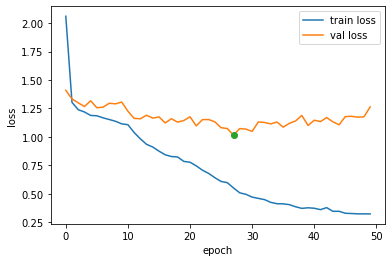

In [14]:
best_params, last_params = train_model(model, criterion, optimizer, dataloaders, epochs=50)

In [15]:
model.load_state_dict(last_params)

<All keys matched successfully>

## evaluate

### visualize output

In [16]:
def evaluate(model,inputs,transform,n_samples=5):
  model.eval()
  
  fig, axs = plt.subplots(3,n_samples, figsize=(10,10))
  for i,input in enumerate(inputs[:n_samples]):    

    axs[0][i].imshow(input)
    axs[2][i].imshow(input)
    input = transform(input).unsqueeze(0).to(device).float()
    with torch.no_grad():
      output = model(input).cpu().squeeze()
    output = np.argmax(output, axis=0).numpy().astype(int)
    
    classes = np.array(VOC_CLASSES)[np.unique(output)]
    classes = classes[1:-1]   # ignore background and void class
    classes = ",".join(classes) 

    output = get_mask(output)
    axs[1][i].imshow(output)
    #axs[1][i].set_title(classes)
    axs[2][i].imshow(output, alpha=0.5)
    #axs[2][i].set_title(classes)
  plt.show()

train sample visualized


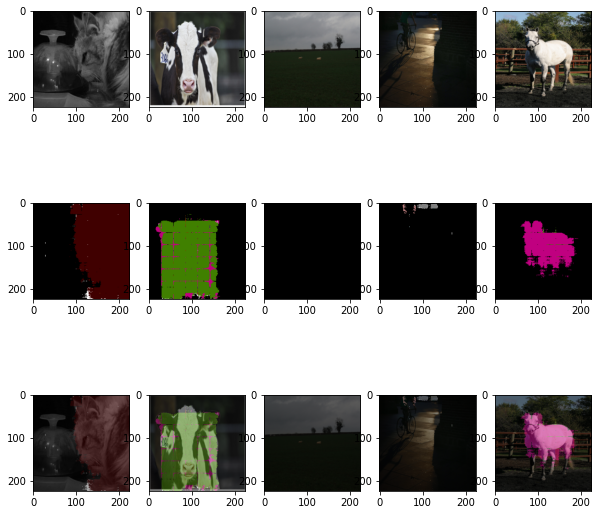

test sample visualized


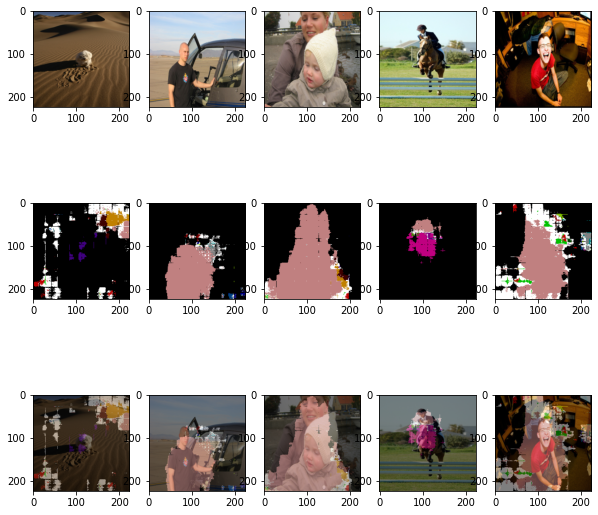

In [17]:
print("train sample visualized")
evaluate(model,train_inputs,trans_in)
print("test sample visualized")
randTestSamples = test_inputs[np.random.choice(test_inputs.shape[0],5,replace=False)]
evaluate(model,randTestSamples,trans_in)

### calculate metrics

In [18]:
def evaluate(model,loader):
  model.eval()
  
  y_true = []
  y_pred = []
  for i, (inputBatch,outTrueBatch) in enumerate(tqdm(loader)):
  
    inputBatch = inputBatch.to(device).float()
    with torch.no_grad():
      outPredBatch = model(inputBatch).argmax(axis=1)

    y_true.extend(outTrueBatch.flatten().cpu().numpy())
    y_pred.extend(outPredBatch.flatten().cpu().numpy())

  print("f1 score")
  print(f1_score(y_true,y_pred, average=None))
  print("micro average")  
  print(f1_score(y_true,y_pred, average="micro"))
  print("macro average")  
  print(f1_score(y_true,y_pred, average="macro"))
  
  print("\njaccard score")
  print(jaccard_score(y_true,y_pred, average=None))
  print("micro average")  
  print(jaccard_score(y_true,y_pred, average="micro"))
  print("macro average")  
  print(jaccard_score(y_true,y_pred, average="macro"))

In [19]:
print("evaluate on training data")
evaluate(model,train_loader)
print("\nevaluate on test data")
evaluate(model,test_loader)

evaluate on training data



f1 score
[0.9539255  0.74286529 0.         0.76068076 0.8294901  0.84579339
 0.9205441  0.87975886 0.89143632 0.60753171 0.8079387  0.88484049
 0.85366634 0.81067129 0.81419363 0.8373921  0.80966036 0.84328428
 0.82900217 0.91320768 0.90996599 0.26385596]
micro average
0.9009690443373387
macro average
0.7731684101380424

jaccard score
[0.91190972 0.5909194  0.         0.61378919 0.70865705 0.73279202
 0.85278528 0.7853299  0.80413632 0.43629842 0.67776607 0.79346541
 0.74469273 0.68162088 0.686616   0.72027044 0.68019273 0.72903331
 0.70794509 0.84027799 0.83480514 0.15197815]
micro average
0.8197849566430994
macro average
0.6675127833262903

evaluate on test data



f1 score
[0.87353167 0.46966229 0.         0.34634426 0.31289198 0.42673451
 0.6752359  0.62667088 0.65445076 0.09541613 0.39816774 0.38019206
 0.53319021 0.41990628 0.50640323 0.63764346 0.35027285 0.34405587
 0.24279659 0.57511596 0.52969595 0.0767775 ]
micro average
0.7574036286680821
macro average
0.4306889131582439

jaccard score
[0.77546049 0.30690107 0.         0.20944157 0.18546055 0.27124126
 0.50970275 0.45631515 0.48638187 0.05009815 0.24857018 0.23471429
 0.36350331 0.26574771 0.33904949 0.46804448 0.21232168 0.20777022
 0.13817216 0.40362299 0.36026287 0.03992128]
micro average
0.6095331083706884
macro average
0.2969410689442905
